# Actividad: Clasificación con máquina de vectores de soporte y redes de neuronas (Mobile Price Classification)

## Introducción

El problema original tiene una breve descripción contextual (.sic):

> Bob has started his own mobile company. He wants to give tough fight to big companies like Apple,Samsung etc.
>
> He does not know how to estimate price of mobiles his company creates. In this competitive mobile phone market you cannot simply assume things. To solve this problem he collects sales data of mobile phones of various companies.
> 
> Bob wants to find out some relation between features of a mobile phone(eg:- RAM,Internal Memory etc) and its selling price. But he is not so good at Machine Learning. So he needs your help to solve this problem.
>
> In this problem you do not have to predict actual price but a price range indicating how high the price is. \citep{Sharma2018}

La variable objetivo es la variable "price_range". En este análisis no se usarán los dos datasets, solo [train.csv](https://www.kaggle.com/iabhishekofficial/mobile-price-classification#train.csv) que corresponde a los datos de entrenamiento.

### Bibliotecas a utilizar

En el presente análisis se comparará el funcionamiento de una SVM y una red neuronal básica por lo tanto se requieren las siguientes bibliotecas.

In [1]:
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Carga de dataset y análisis descriptivo de datos

In [2]:
df_train = pd.read_csv("ds/train.csv")

Según los datos proporcionados no existen valores perdidos. Además todas las columnas tienen valores numéricos.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [4]:
df_train.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.51850,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.49500,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.52225,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.50950,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.30950,4.341444,0.0,1.00,3.0,7.00,19.0
four_g,2000.0,0.52150,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.04650,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.50175,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.24900,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.52050,2.287837,1.0,3.00,4.0,7.00,8.0


Aún así parece que no todas las variables son realmente numéricas, pues no caen en valores continuos. Como ejemplo es posible observar la columna objetivo, la cual por medio de números distingue cuatro categorías. Debido a la falta de metadatos en el dataset no es posible saber con certeza a que corresponde cada una, sin embargo, una clasificación tradicional es: el segmento de entra (0), la gama media (1), la gama alta (2) y la gama premium (3).

Text(0.5, 1.0, 'Frecuencias de price_range')

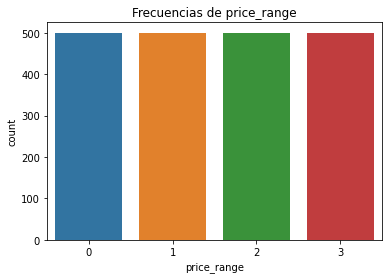

In [5]:
sns.countplot(x='price_range', data=df_train)
plt.title('Frecuencias de price_range', fontsize=12)

### Variables categóricas

Es importante observar entonces que datos son categóricos y examinarlos como tal.

In [6]:
for i in df_train.columns:
    print(f'Valores posibles de {i.title()}: {df_train[i].unique()}')

Valores posibles de Battery_Power: [ 842 1021  563 ... 1139 1467  858]
Valores posibles de Blue: [0 1]
Valores posibles de Clock_Speed: [2.2 0.5 2.5 1.2 1.7 0.6 2.9 2.8 2.1 1.  0.9 1.1 2.6 1.4 1.6 2.7 1.3 2.3
 2.  1.8 3.  1.5 1.9 2.4 0.8 0.7]
Valores posibles de Dual_Sim: [0 1]
Valores posibles de Fc: [ 1  0  2 13  3  4  5  7 11 12 16  6 15  8  9 10 18 17 14 19]
Valores posibles de Four_G: [0 1]
Valores posibles de Int_Memory: [ 7 53 41 10 44 22 24  9 33 17 52 46 13 23 49 19 39 47 38  8 57 51 21  5
 60 61  6 11 50 34 20 27 42 40 64 14 63 43 16 48 12 55 36 30 45 29 58 25
  3 54 15 37 31 32  4 18  2 56 26 35 59 28 62]
Valores posibles de M_Dep: [0.6 0.7 0.9 0.8 0.1 0.5 1.  0.3 0.4 0.2]
Valores posibles de Mobile_Wt: [188 136 145 131 141 164 139 187 174  93 182 177 159 198 185 196 121 101
  81 156 199 114 111 132 143  96 200  88 150 107 100 157 160 119  87 152
 166 110 118 162 127 109 102 104 148 180 128 134 144 168 155 165  80 138
 142  90 197 172 116  85 163 178 171 103  83 140 194 146 

Las variables categóricas parecen ser: `blue`, `dual_sim`, `four_g`, `three_g`, `touch_screen`, `wifi` y `price_range`. Debido a que `price_range` es nuestra variable objetivo, en seguida se grafican las frecuencias de las otras variables categóricas tomando en cuenta el rango de precios.

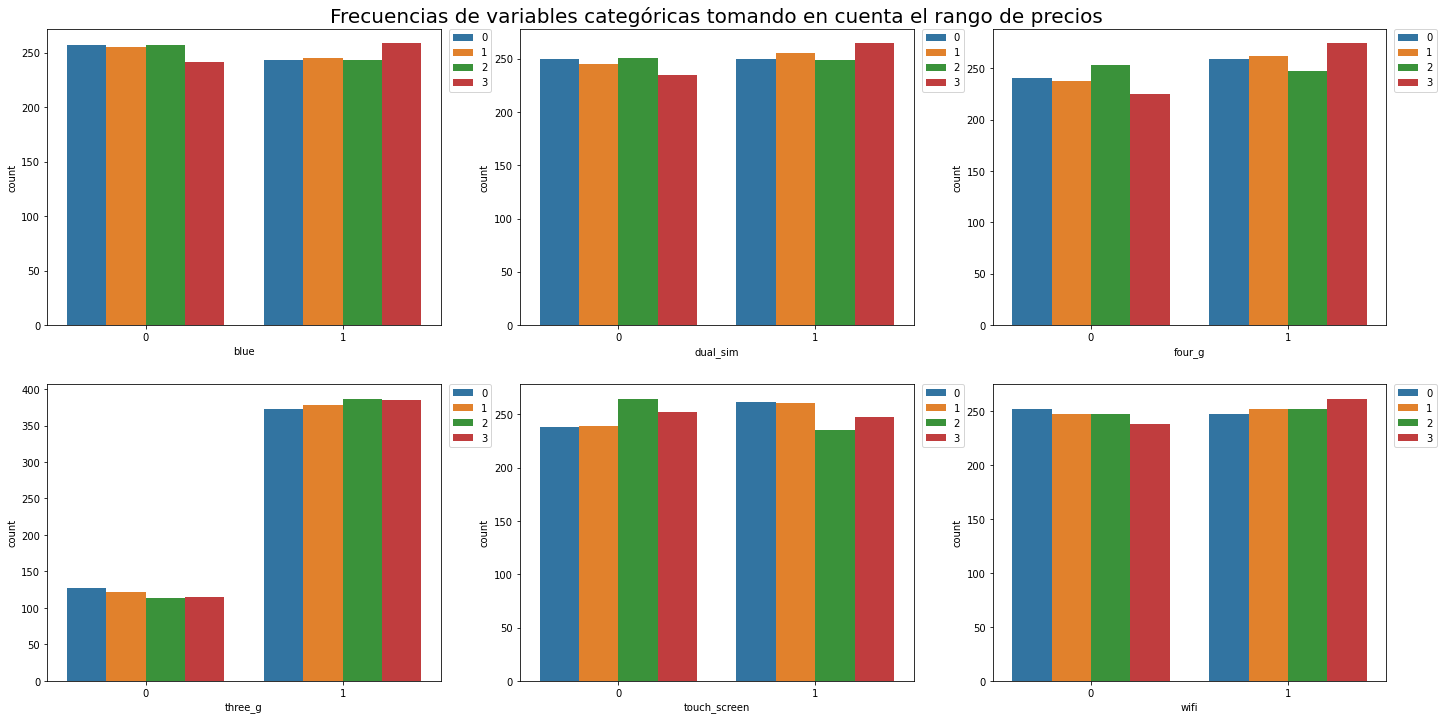

In [7]:
cv=['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
fig=plt.figure(figsize=(24,12))
plt.title('Frecuencias de variables categóricas tomando en cuenta el rango de precios',fontdict={'fontsize':20})
plt.axis('off')

for i in range(len(cv)):
    fig.add_subplot(2,3,i+1)
    sns.countplot(data=df_train,x=cv[i], hue='price_range')
    plt.legend(bbox_to_anchor=(1.02, 1), borderaxespad=0)

Es posible observar que los teléfonos más costosos cuentan con más de estas características, salvo en el caso de `touch_screen`, donde no hay diferencia frecuencial visible. La variable `three_g` parece ser más significativa ya que la división es un poco más clara. También hay que matizar que esta diferencia no es suficiente para distinguir invariablemente las categorías de rango de precio.

### Variables numéricas

Se repetirá el procedimiento anterior procedimiento para las variables que son efectivamente numéricas pues servirá para observar el contraste entre los tipos de variables.

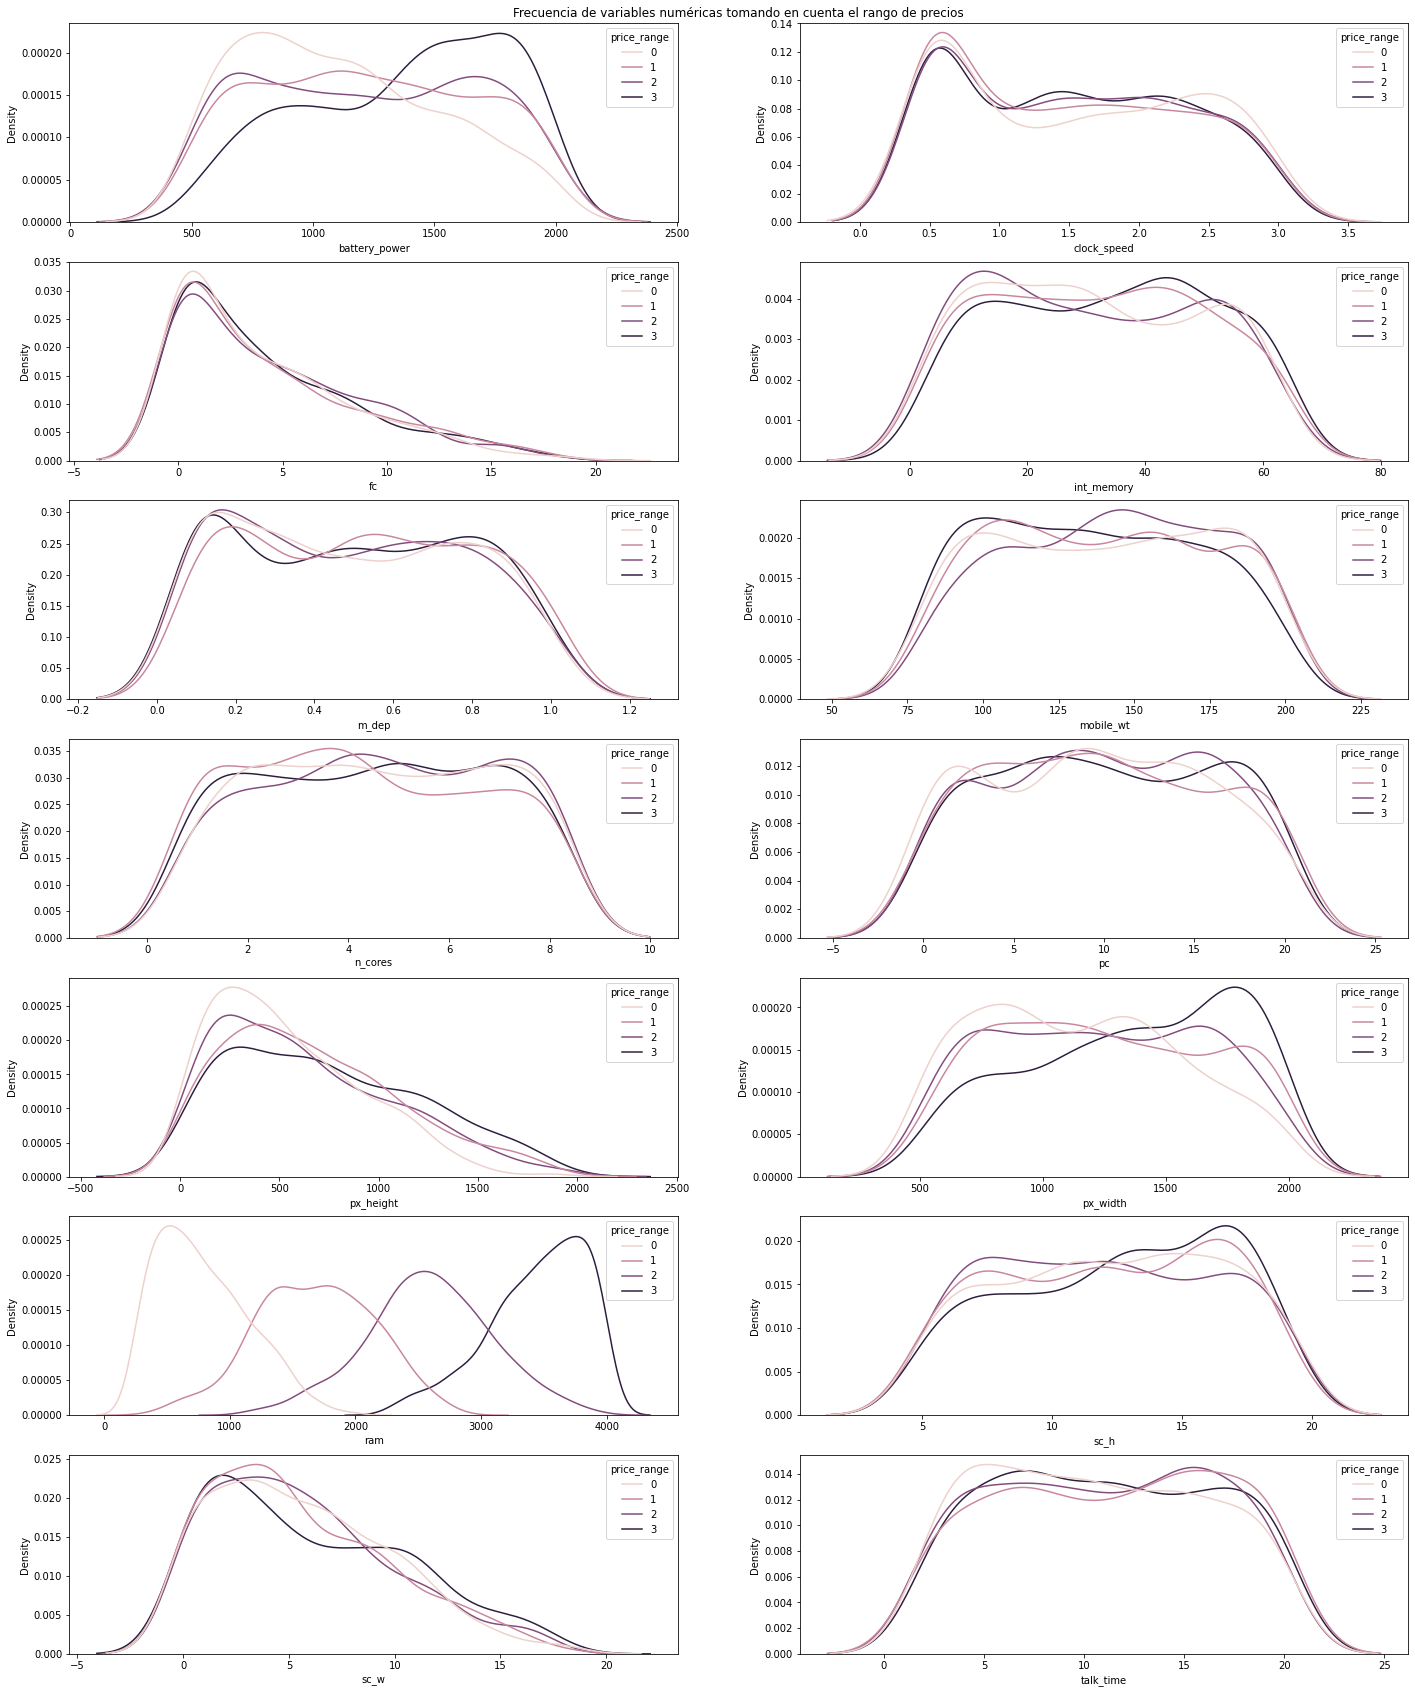

In [8]:
nv=['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']
fig=plt.figure(figsize=(24,30))
plt.title('Frecuencia de variables numéricas tomando en cuenta el rango de precios')
plt.axis('off')

for i in range(len(nv)):
    fig.add_subplot(7,2,i+1)
    sns.kdeplot(data=df_train, x=nv[i], hue='price_range')

La dentro de las gráficas anteriores lo más destacado es aquella que representa la variable `ram`. En dicha representación se distinguen muy claramente los segmentos de precio, es posible pensar que que la variable `ram`, tenga una correlación alta respecto a `price_range`, mientras otras como `clock_speed` sean de muy poca relevancia.

## Matriz de correlación

La matriz es indispensable para distinguir la importancia de las variables y así pensar en un mejor modelo.

<AxesSubplot:>

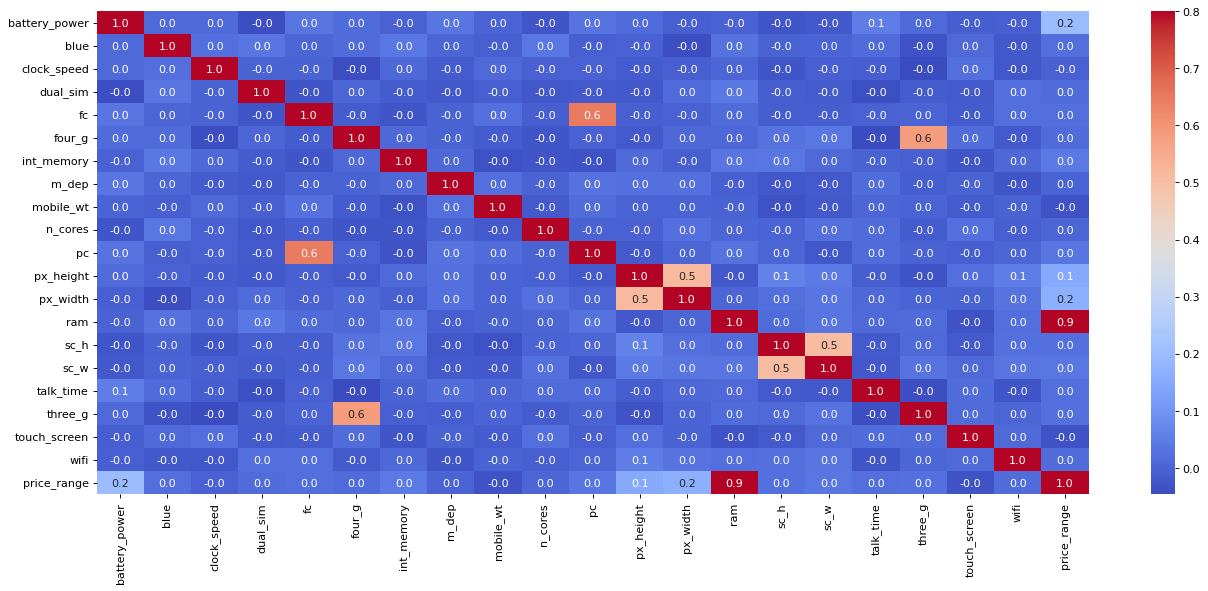

In [9]:
plt.figure(figsize=(20,8),dpi=80)
corrmat = df_train.corr()
sns.heatmap(corrmat, cmap='coolwarm', vmax=.8, fmt='.1f', annot=True)

In [10]:
df_train.corr()['price_range'].sort_values(ascending=False)[1:21]

ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

Tal y como se dijo anteriormente, la variable `ram` tiene una alta correlación con la variable objetivo.

## SVM

Se implementará una SVM. Al trabajar con métodos supervisados es necesario dividir el dataframe en dos partes.

In [11]:
train, test = train_test_split(df_train, test_size=0.2)
predictors = cv + nv
#predictors = ['ram', 'battery_power', 'px_width', 'px_height', 'int_memory']
target = ['price_range']

Ahora, ante la diversidad de hiperparámetros se crea la SVM al mismo tiempo que se busca el mejor modelo posible. Este proceso es muy lento, a continuación se muestran solo los hiperparámetros más relevantes, otros fueron descartados pues en una ejecución individual dieron resultados deficientes.

In [12]:
parameters = [{'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'C': [0.5, 1.0, 1.5, 2.0, 2.5]}]
svmc = RandomizedSearchCV(svm.SVC(decision_function_shape='ovr'), param_distributions=parameters, cv=5, scoring='accuracy')
svmc.fit(train[predictors], np.ravel(train[target]))
svmc.best_params_

{'kernel': 'linear', 'gamma': 'auto', 'C': 0.5}

Accuracy:  0.975


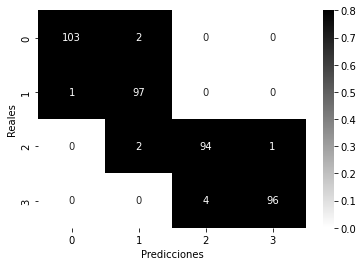

In [13]:
svm_predicted = svmc.predict(test[predictors])
crosstab = sns.heatmap(pd.crosstab(test[target].values.ravel(), svm_predicted),
                cmap='gist_yarg', vmax=.8, fmt='g', annot=True)
crosstab.set_xlabel('Predicciones')
crosstab.set_ylabel('Reales')
print("Accuracy: ", metrics.accuracy_score(svm_predicted, np.ravel(test[target])))

Los resultados de la SVM resultan bastante prometedores, la precisión alcanzada es muy alta, en alguna ejecución llegó a ser del 99%, sin embargo, se consigue en pocos casos.

## Red Neuronal

La red neuronal ha resultado ser más complicada de implementar debido a que requiere el diseño de la las capaz de la red. Aquí se presenta una estructura básica. \citep{rickytb2021, Keras2022}

In [14]:
nn = Sequential()
nn.add(Dense(units=16, input_dim=20, activation='relu'))
nn.add(Dense(units=12, activation='relu'))
nn.add(Dense(units=4, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
nn.fit(train[predictors], np.ravel(train[target]), epochs=550, batch_size=4, verbose=0)

2022-04-15 06:14:12.733464: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-15 06:14:12.733513: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-15 06:14:12.733549: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-genomorro-2dunir-2duy5jhwqu): /proc/driver/nvidia/version does not exist
2022-04-15 06:14:12.734649: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-04-15 06:14:12.765753: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2022-04-15 06:14:12.771347: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b1568017f0 initialized for platform Ho

In [17]:
nn_pred = nn.predict(test[predictors])

El resultado de la red neuronal no es legible inmediatamente, se requiere convertir las predicciones a sus respectivas etiquetas. \citep{rickytb2021}

In [18]:
# Convertir las predicciones a sus respectivas etiquetas
def pred_to_label(predictions):
    pred = list()
    for i in range(len(predictions)):
        pred.append(np.argmax(predictions[i]))
    return pred

Accuracy:  0.9525


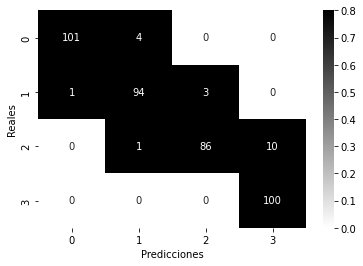

In [19]:
nn_predicted = pred_to_label(nn_pred)
crosstab = sns.heatmap(pd.crosstab(test[target].values.ravel(), np.array(nn_predicted)),
                cmap='gist_yarg', vmax=.8, fmt='g', annot=True)
crosstab.set_xlabel('Predicciones')
crosstab.set_ylabel('Reales')
print("Accuracy: ", metrics.accuracy_score(nn_predicted, np.ravel(test[target])))

La red neuronal no ha alcanzado la gran precisión que logró la SVM pero el resultado no se ha alejado realmente. Si se considera que este modelo fue creado a partir de la documentación básica de la biblioteca que lo implementa y no ha sido totalmente personalizado, es posible pensar que el resultado es positivo y podría alcanzar mejores predicciones con mayor tiempo.

## Comparación entre métodos

Como ya se ha visto, la precisión conseguida por la SVM es superior a la obtenida en la red neuronal. Habrá que considerar que la potencia de computo ha limitado la red neuronal, por lo tanto, para comparar mejor los algoritmos se usarán las métricas proporcionadas por `sklearn`.

In [20]:
print(metrics.classification_report(test[target].values.ravel(), svm_predicted))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       105
           1       0.96      0.99      0.97        98
           2       0.96      0.97      0.96        97
           3       0.99      0.96      0.97       100

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.98      0.97      0.98       400



In [21]:
print(metrics.classification_report(test[target].values.ravel(), nn_predicted))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       105
           1       0.95      0.96      0.95        98
           2       0.97      0.89      0.92        97
           3       0.91      1.00      0.95       100

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



Los resultados son realmente parejos. Los mejores números presentados por la SVM no hacen gran diferencia. El _recall_, la capacidad del clasificador para encontrar todas las muestras positivas pueden tener números iguales según sea la ejecución del _notebook_ de Python. El _f1-score_ que se interpreta como una media armónica de precisión y recall, llega en alguna categoría, de cualquiera de los modelos, a su mejor valor (1), según sea la ejecución del notebook.

Parece que con la implementación aquí elaborada de ambos modelos, dependerá más de ejecutar el notebook hasta encontrar una ejecución que logre los mejores resultados que el usuario pueda esperar. Ahora bien, es importante señalar que la red neuronal parece menos consistente entre categorías que la SVM, en otras palabras, la SVM clasifica cada una de las categorías con presiciones similares, mientras que en la red neuronal se observa que tiene notablemente menor presición en alguna de las categorías.

## Conclusión

En el presente análisis se utilizó un dataset llamado _Mobile price classification_. Se realizó un estudio estadístico general del dataset y se encontraron dos mil muestras en el mismo.

Se decidió aplicar dos algoritmos avanzados: SVM y redes neuronales. Estos algoritmos requieren trabajo al afinar los hiperparámetros de cada modelo, si bien son herramientas muy poderosas, también hay que decir que ajustarlas para solucionar el problema puede ser más costoso que usar otro algoritmo más básico.

En ejemplos sencillos como el resuelto en este documento, dichos hiperparámetros son ajustables con cierta sencillez. Aún así, la fase de entrenamiento es más lenta si se considera que el dataset es de solo 2000 muestras. Si a lo anterior se sumaran muestras con overlapping, la SVM particularmente tenderá a cometer un mayor número de errores. La red neuronal incluso sugería el uso de una tarjeta gráfica y otras características para el CPU. Este mensaje puede observarse en la correspondiente ejecución de la red neuronal del presente análisis.

Si el dataset tiene muchas dimensiones, la SVM puede ser una excelente alternativa. Aunque no podrán ser visualizadas gráficamente, este algoritmo lidiará bien con el dataset incluso si el número de dimensiones supera el número de muestras, como en el procesamiento de imágenes. Por su parte, las redes neuronales pueden ser más útiles con información más desestructurada o en datos más complejos sin querer abusar del método prueba/error.